Selecting GPU

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 3:.2f} GB")
        print(f"Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 3:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available. Number of GPUs: 1
Current GPU: NVIDIA RTX A6000
GPU 0: NVIDIA RTX A6000
Memory Allocated: 0.00 GB
Memory Cached: 0.00 GB


## Library Imports

In [2]:
from matplotlib import pyplot as plt
from monai.data import DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ToTensord,
)
import torch
import torch.nn as nn

### Directory

In [3]:
root_dir = "/home/user/Desktop/Abul Hasan/Dataset/BraTS2020/BraTS2020_TrainingData/Combined"
output_dir = "/home/user/Desktop/Abul Hasan/OUTPUT"

### UNETR + CBAM Architecture

In [4]:
from utils.config import cfg
from blocks.Conv3DBlock import Conv3DBlock
from blocks.Deconv3DBlock import Deconv3DBlock
from blocks.CBAM import CBAM
from blocks.Transformer import Transformer
from blocks.SingleDeconv3DBlock import SingleDeconv3DBlock
from blocks.SingleConv3DBlock import SingleConv3DBlock


class UNETR(nn.Module):
    def __init__(self, img_shape=cfg.unetr.img_shape, input_dim=cfg.unetr.input_dim, output_dim=cfg.unetr.output_dim, embed_dim=cfg.unetr.embed_dim, patch_size=cfg.unetr.patch_size, num_heads=cfg.unetr.num_heads, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = cfg.unetr.num_layers
        self.ext_layers = cfg.unetr.extract_layers

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim=input_dim,
            embed_dim=embed_dim,
            cube_size=img_shape,
            patch_size=patch_size,
            num_heads=num_heads,
            num_layers=self.num_layers,
            dropout=dropout,
            extract_layers=self.ext_layers
        )

        # U-Net Decoder
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 32, 3),
            Conv3DBlock(32, 64, 3)
        )

        self.decoder3 = nn.Sequential(
            Deconv3DBlock(embed_dim, 512),
            Deconv3DBlock(512, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder6 = nn.Sequential(
            Deconv3DBlock(embed_dim, 512),
            Deconv3DBlock(512, 256),
        )

        self.decoder9 = Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = nn.Sequential(
            Conv3DBlock(1024, 512),
            Conv3DBlock(512, 512),
            Conv3DBlock(512, 512),
            CBAM(512),  # Adding CBAM
            SingleDeconv3DBlock(512, 256)
        )

        self.decoder6_upsampler = nn.Sequential(
            Conv3DBlock(512, 256),
            Conv3DBlock(256, 256),
            CBAM(256),  # Adding CBAM
            SingleDeconv3DBlock(256, 128)
        )

        self.decoder3_upsampler = nn.Sequential(
            Conv3DBlock(256, 128),
            Conv3DBlock(128, 128),
            CBAM(128),  # Adding CBAM
            SingleDeconv3DBlock(128, 64)
        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(128, 64),
            Conv3DBlock(64, 64),
            SingleConv3DBlock(64, output_dim, 1)
        )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output


### Data Loader

In [15]:
from utils.dataloader import ConvertToMultiChannelBasedOnBratsClassesd
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"], spatial_size=cfg.unetr.img_shape, mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

In [21]:
from utils.dataloader import BratsDataset
train_ds = BratsDataset(
    root_dir=root_dir,
    section="training",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_ds = BratsDataset(
    root_dir=root_dir,
    section="validation",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)


### Visualization

image shape: torch.Size([4, 96, 96, 96])


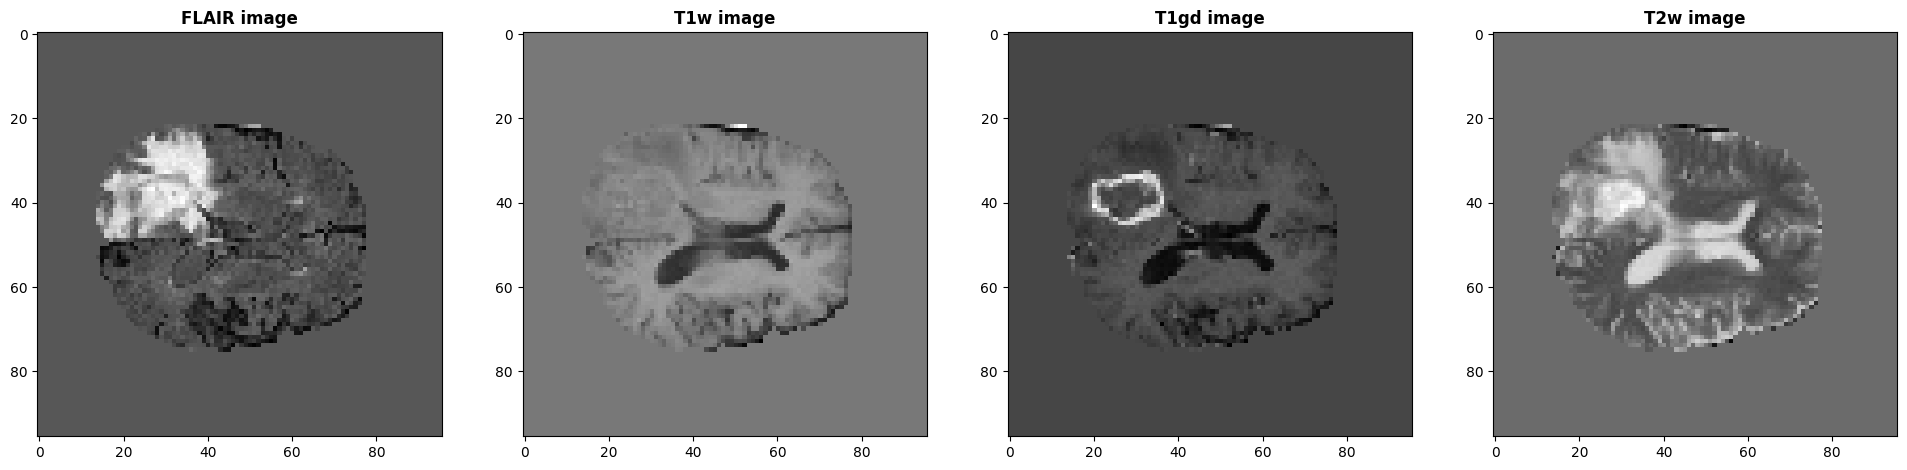

label shape: torch.Size([3, 96, 96, 96])


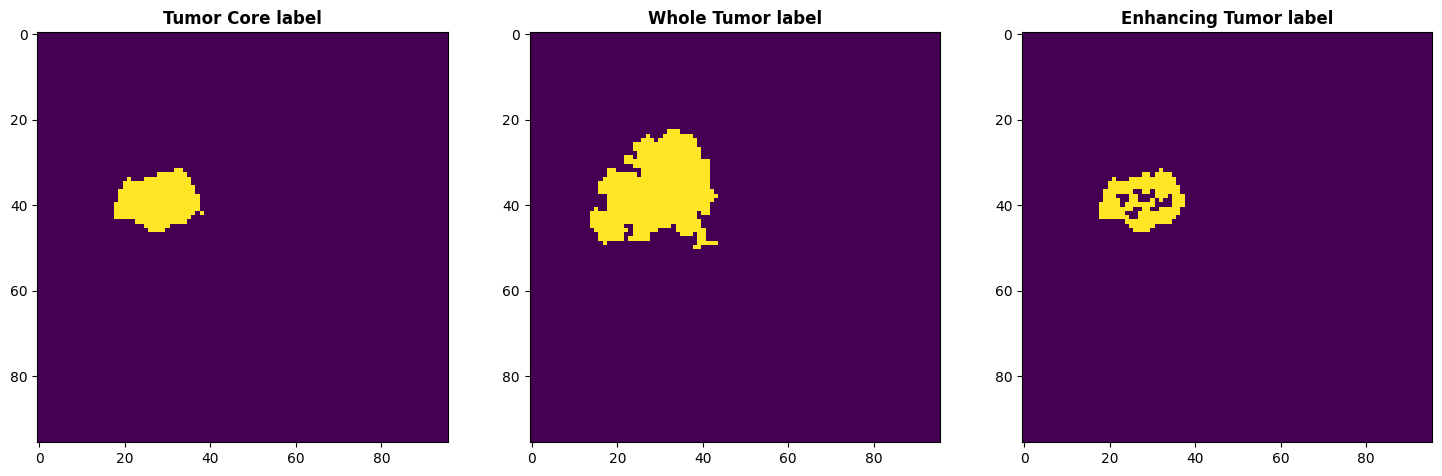

In [17]:
image_channels = ['FLAIR', 'T1w', 'T1gd', 'T2w']
label_channels = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor']

# pick one image from BratsDataset to visualize and check the 4 channels
val_data_example = val_ds[27]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(len(image_channels)):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{image_channels[i]} image", weight='bold')
    plt.imshow(val_data_example["image"][i, :, :, val_data_example['image'].shape[-1] // 2], cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(len(label_channels)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{label_channels[i]} label", weight='bold')
    plt.imshow(val_data_example["label"][i, :, :, val_data_example['image'].shape[-1] // 2])
plt.show()

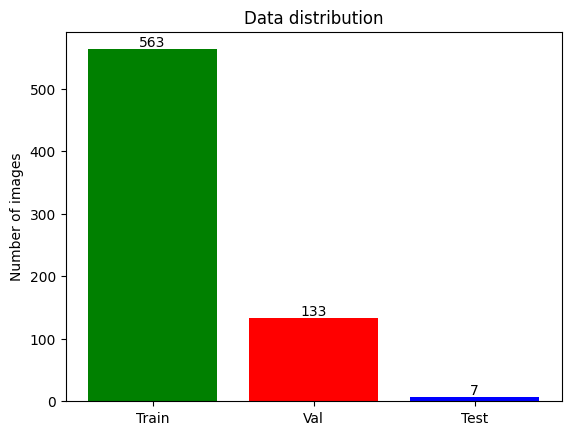

In [22]:
from utils.plot import plot_data_distribution 
val_frac = val_ds.val_frac
test_frac = val_ds.test_frac

num_train = len(train_ds)
num_val = len(val_ds)
num_test = int(test_frac * num_val / val_frac)

plot_data_distribution(num_train, num_val, num_test)

### Define Model,Loss & Optimizer

In [9]:
import torch
from monai.losses import DiceCELoss
val_interval = 1
VAL_AMP = True
device = torch.device("cpu:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

model = UNETR(
    img_shape=cfg.unetr.img_shape,
    input_dim=cfg.unetr.input_dim,
    output_dim=cfg.unetr.output_dim,
    embed_dim=cfg.unetr.embed_dim,
    patch_size=cfg.unetr.patch_size,
    num_heads=cfg.unetr.num_heads,
    dropout=0.1
).to(device)


loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True, include_background=True)
optimizer = torch.optim.Adam(model.parameters(), cfg.learning_rate, weight_decay=cfg.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epoch)
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True, logit_thresh=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=cfg.unetr.img_shape,
            sw_batch_size=1,
            predictor=model,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


cuda:0


### Training

In [10]:
import time 
import os
training = True
best_metric = -1
best_metric_epoch = -1
not_improved_epoch = 0
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(cfg.epoch):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{cfg.epoch}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                not_improved_epoch = 0
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            else:
                not_improved_epoch += 1
                if not_improved_epoch >= cfg.patience:
                    training = False
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    
    if not training:
        print("Training process is stopped early....")
        break
total_time = time.time() - total_start

192/281, train_loss: 1.3268, step time: 0.2495
193/281, train_loss: 1.3294, step time: 0.2474
194/281, train_loss: 1.3201, step time: 0.2467
195/281, train_loss: 1.3547, step time: 0.2456
196/281, train_loss: 1.3324, step time: 0.2436
197/281, train_loss: 1.3173, step time: 0.2442
198/281, train_loss: 1.2996, step time: 0.2442
199/281, train_loss: 1.3269, step time: 0.2487
200/281, train_loss: 1.3230, step time: 0.2532
201/281, train_loss: 1.3237, step time: 0.2630
202/281, train_loss: 1.3074, step time: 0.2505
203/281, train_loss: 1.3135, step time: 0.2531
204/281, train_loss: 1.3078, step time: 0.2571
205/281, train_loss: 1.2963, step time: 0.2539
206/281, train_loss: 1.3027, step time: 0.2495
207/281, train_loss: 1.3095, step time: 0.2489
208/281, train_loss: 1.3234, step time: 0.2499
209/281, train_loss: 1.2922, step time: 0.2463
210/281, train_loss: 1.3055, step time: 0.2486
211/281, train_loss: 1.3181, step time: 0.2477
212/281, train_loss: 1.3007, step time: 0.2420
213/281, trai

In [11]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.9048 at epoch: 118, total time: 64841.09350204468.


### Plot Metrics

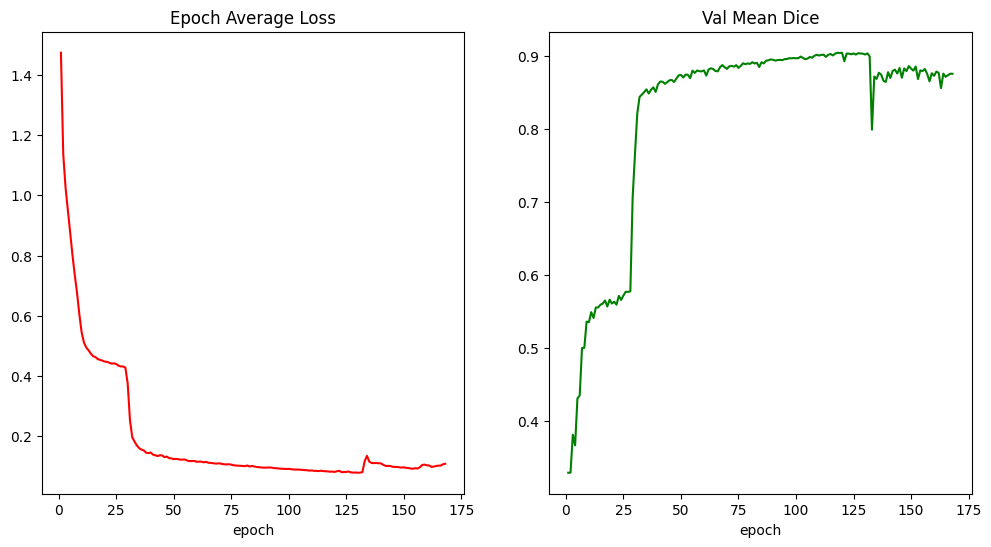

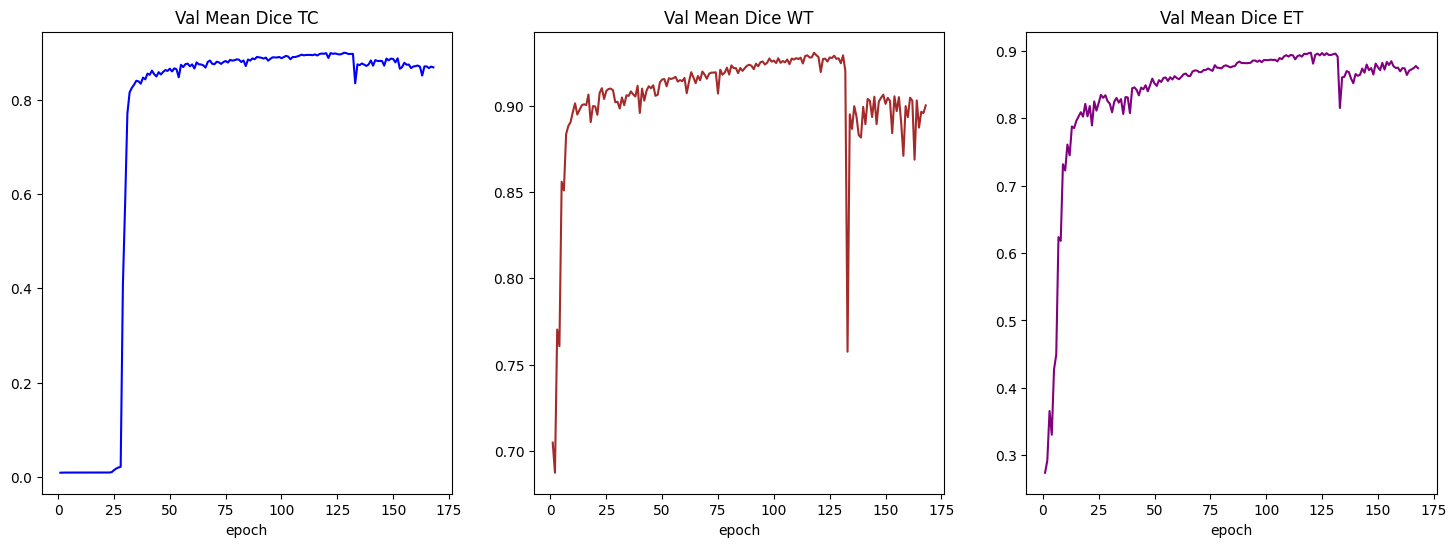

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

### Testing 

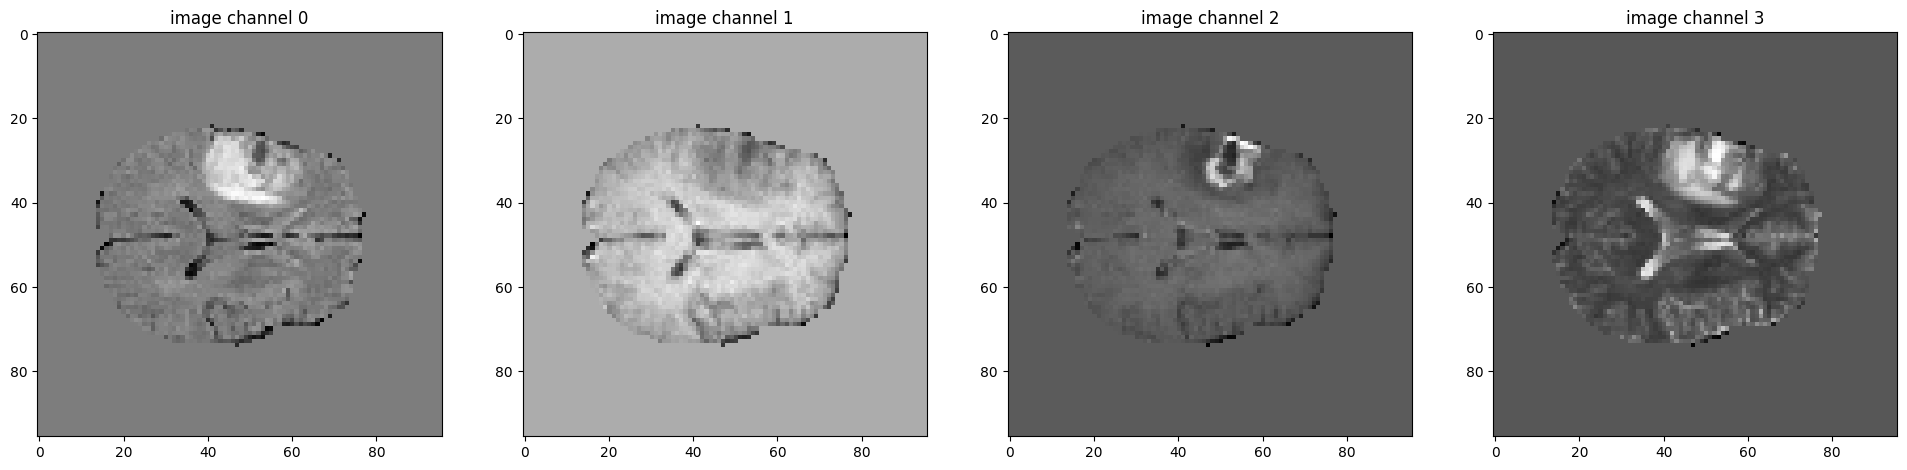

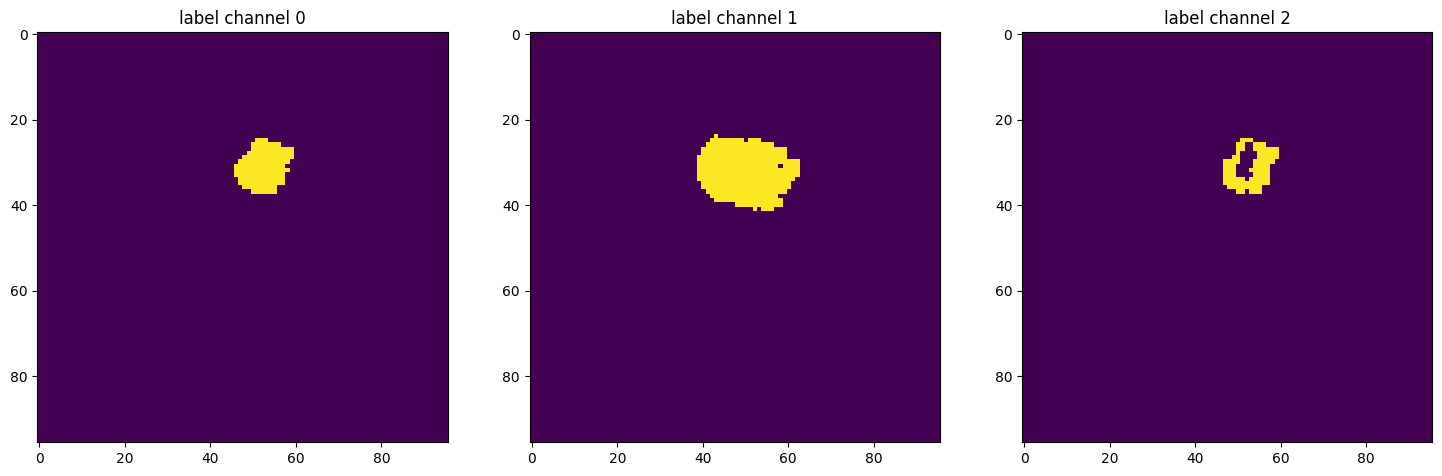

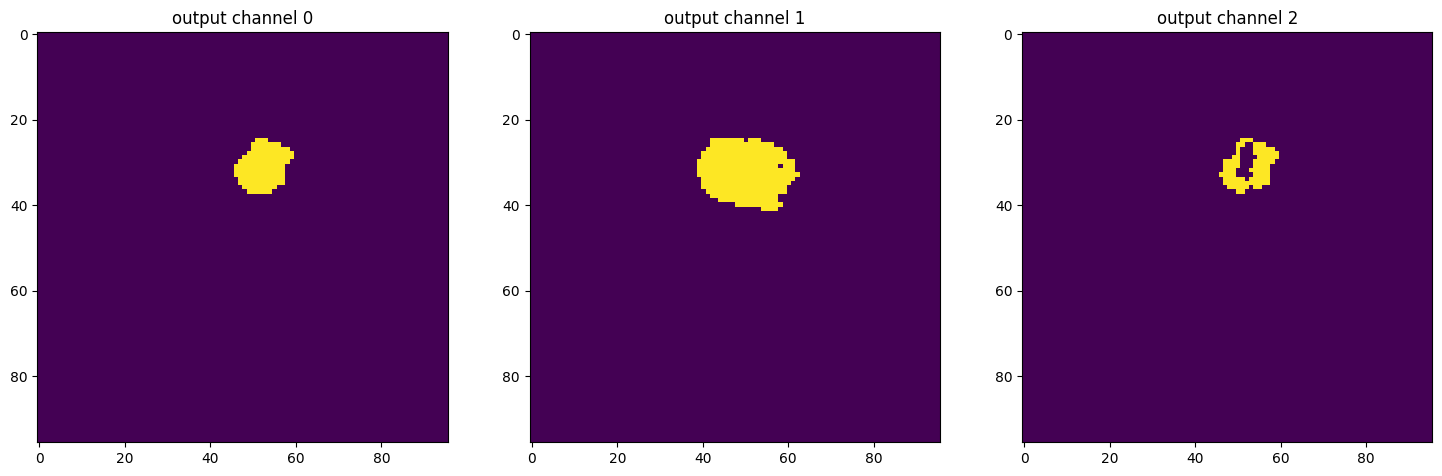

In [13]:
model.load_state_dict(torch.load(os.path.join(output_dir, "best_metric_model.pth")))
model.eval()
                     
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_data = val_ds[1]
    val_input = val_data["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_data["image"][i, :, :, val_input.shape[-1] // 2].detach().cpu(), cmap="gray")
    plt.show()
    
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_data["label"][i, :, :, val_input.shape[-1] // 2].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, val_input.shape[-1] // 2].detach().cpu())
    plt.show()

In [14]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear", "nearest"]
        ),
        Resized(keys=["image", "label"], spatial_size=cfg.unetr.img_shape, mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

test_ds = BratsDataset(
    root_dir=root_dir,
    section="test",
    transform=transform,
    cache_num=0
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

##### model.load_state_dict(torch.load(os.path.join(output_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        test_outputs = inference(test_inputs)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric(y_pred=test_outputs, y=test_labels)
        dice_metric_batch(y_pred=test_outputs, y=test_labels)

    metric = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()
    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on test image: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on test image:  0.9408921003341675
metric_tc: 0.9583
metric_wt: 0.9520
metric_et: 0.9049
